In [1]:
# import attack_kernelbased
import attack_fgsm_dnn
import attack_df_dnn
# import attack_jsma
import attack_gen_dnn
import dataloader
import spatial

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import time
import onlinehd
import DNNmodels
import pickle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tqdm

In [2]:
device = 'cpu'

In [3]:
X_train, X_test, y_train, y_test = dataloader.load(dataset_name='isolet')

classes = y_train.unique().size(0)
features = X_train.size(1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([6238, 617]),
 torch.Size([1559, 617]),
 torch.Size([6238]),
 torch.Size([1559]))

In [4]:
X_test = X_test[:1000]
y_test = y_test[:1000]

## DNN

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=617, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=26, bias=True)
  )
)
Epoch 1
-------------------------------
loss: 3.257603  [    0/ 6238]
Epoch 2
-------------------------------
loss: 1.207749  [    0/ 6238]
Epoch 3
-------------------------------
loss: 0.715885  [    0/ 6238]
Epoch 4
-------------------------------
loss: 0.569334  [    0/ 6238]
Epoch 5
-------------------------------
loss: 0.392315  [    0/ 6238]
Epoch 6
-------------------------------
loss: 0.512055  [    0/ 6238]
Epoch 7
-------------------------------
loss: 0.258783  [    0/ 6238]
Epoch 8
-------------------------------
loss: 0.251408  [    0/ 6238]
Epoch 9
-------------------------------
loss: 0.121673  [    0/ 6238]
INFO: Early stopping counter 1 of 5
Epoch 10
-------------------------------
loss: 0.095692  [   

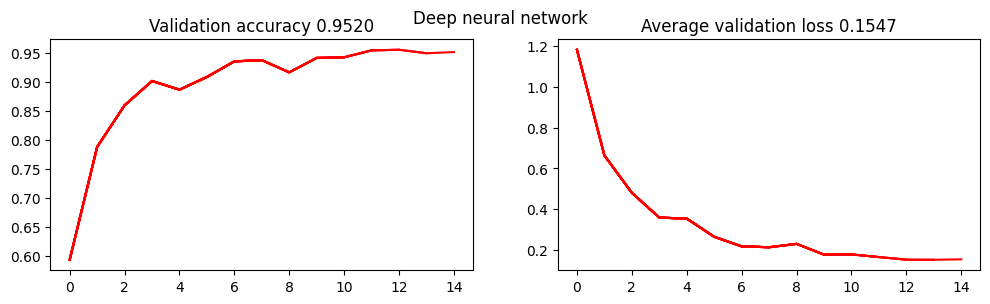

In [5]:
BATCH_SIZE = 64
EPOCHS = 15

training_data = DNNmodels.CustomDataset(X_train, y_train, model_type='ffnn')
val_data = DNNmodels.CustomDataset(X_test, y_test, model_type='ffnn')
# create Dataloader for cnn
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

model_cnn = DNNmodels.NeuralNetwork(num_classes=classes, flatten_layer=False, input_dim=features).to(device)
print(model_cnn)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.0005)
early_stop_callback = DNNmodels.EarlyStopping()

fig, axs = plt.subplots(1,2, figsize=(12,3))
plt.suptitle('Deep neural network')
result = {'avg_loss':[], 'acc':[], 'epoch':[]}

for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    DNNmodels.train(train_dataloader, model_cnn, loss_fn, optimizer)
    DNNmodels.test(val_dataloader, model_cnn, loss_fn, result)
    result['epoch'].append(t)
    early_stop_callback(result['avg_loss'][-1])
    if early_stop_callback.early_stop:
        break
    DNNmodels.plot_results(axs, result)

In [6]:
torch.save(model_cnn.state_dict(), './model_dnn_isolet.pt')

In [5]:
model_dnn = DNNmodels.NeuralNetwork(num_classes=classes, flatten_layer=False, input_dim=features)
model_dnn.load_state_dict(torch.load('./model_dnn_isolet.pt'))
model_dnn.eval()

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=617, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=26, bias=True)
  )
)

In [6]:
with open('./onlinehd_isolet.pickle', 'br') as f:
    model_onlinehd = pickle.load(f)

### FGSM

In [7]:
epsilons = np.linspace(0.01, 0.1, 10) # torch.Tensor([0.01, 0.03, 0.07, 0.1])
verbose = False
criterion = nn.CrossEntropyLoss()
#criterion = lambda output, model, label: (spatial.cos_cdist(output, model) - label).mean()
#criterion = lambda output, model, label: output.mean()
N_VAL_SAMPLES = X_test.data.shape[0]

attack_samples, acc_results = attack_fgsm_dnn.attack(
    model_dnn, X_train.reshape(len(X_train), features), X_test.reshape(len(X_test), features), y_test, epsilons, classes, criterion, N_VAL_SAMPLES, 'cpu',
    input_dim=features, model_type='dnn')

100%|██████████| 1000/1000 [00:00<00:00, 1088.69it/s]



FGSM Attack with epsilon = 0.01000 | Elapsed time: 0.9539192500000002 seconds.
Accuracy: Before the attack -> 95.20%	|	After the attack -> 93.40%
mean of norm=0.009999996982514858


100%|██████████| 1000/1000 [00:00<00:00, 1290.97it/s]



FGSM Attack with epsilon = 0.02000 | Elapsed time: 0.795622916000001 seconds.
Accuracy: Before the attack -> 95.20%	|	After the attack -> 90.40%
mean of norm=0.019999997690320015


100%|██████████| 1000/1000 [00:00<00:00, 1630.36it/s]



FGSM Attack with epsilon = 0.03000 | Elapsed time: 0.620443250000001 seconds.
Accuracy: Before the attack -> 95.20%	|	After the attack -> 88.00%
mean of norm=0.029999982565641403


100%|██████████| 1000/1000 [00:00<00:00, 1667.94it/s]



FGSM Attack with epsilon = 0.04000 | Elapsed time: 0.6064262500000019 seconds.
Accuracy: Before the attack -> 95.20%	|	After the attack -> 84.10%
mean of norm=0.03999999910593033


100%|██████████| 1000/1000 [00:00<00:00, 1649.58it/s]



FGSM Attack with epsilon = 0.05000 | Elapsed time: 0.613734749999999 seconds.
Accuracy: Before the attack -> 95.20%	|	After the attack -> 80.60%
mean of norm=0.05000000447034836


100%|██████████| 1000/1000 [00:00<00:00, 1485.85it/s]



FGSM Attack with epsilon = 0.06000 | Elapsed time: 0.6841683749999987 seconds.
Accuracy: Before the attack -> 95.20%	|	After the attack -> 75.40%
mean of norm=0.0599999763071537


100%|██████████| 1000/1000 [00:00<00:00, 1557.04it/s]



FGSM Attack with epsilon = 0.07000 | Elapsed time: 0.6549525420000002 seconds.
Accuracy: Before the attack -> 95.20%	|	After the attack -> 67.90%
mean of norm=0.06999999284744263


100%|██████████| 1000/1000 [00:00<00:00, 1608.65it/s]



FGSM Attack with epsilon = 0.08000 | Elapsed time: 0.6283722080000018 seconds.
Accuracy: Before the attack -> 95.20%	|	After the attack -> 60.70%
mean of norm=0.07999999821186066


100%|██████████| 1000/1000 [00:00<00:00, 1640.49it/s]



FGSM Attack with epsilon = 0.09000 | Elapsed time: 0.617060249999998 seconds.
Accuracy: Before the attack -> 95.20%	|	After the attack -> 53.50%
mean of norm=0.09000000357627869


100%|██████████| 1000/1000 [00:00<00:00, 1598.97it/s]


FGSM Attack with epsilon = 0.10000 | Elapsed time: 0.6329750000000018 seconds.
Accuracy: Before the attack -> 95.20%	|	After the attack -> 45.60%
mean of norm=0.10000000894069672


In [8]:
for e, X_test_noised in zip(epsilons, attack_samples):
    yhat_test_onlinehd = model_onlinehd(X_test_noised.reshape(-1, features))
    yhat_test_dnn = model_dnn(X_test_noised.reshape(-1, features)).argmax(1)

    onlinehd_attacked_acc = (y_test == yhat_test_onlinehd).float().mean().item()
    dnn_attacked_acc = (y_test == yhat_test_dnn).float().mean().item()
    distance = (X_test_noised.reshape(-1, features) - X_test).norm(dim=-1).mean().item()

    print(e, distance, onlinehd_attacked_acc, dnn_attacked_acc)

0.01 0.009999996982514858 0.9440000057220459 0.9340000152587891
0.020000000000000004 0.019999997690320015 0.9319999814033508 0.9039999842643738
0.030000000000000006 0.029999982565641403 0.9179999828338623 0.8799999952316284
0.04000000000000001 0.03999999910593033 0.9079999923706055 0.8410000205039978
0.05000000000000001 0.05000000447034836 0.8939999938011169 0.8059999942779541
0.06000000000000001 0.0599999763071537 0.8849999904632568 0.7540000081062317
0.07 0.06999999284744263 0.8700000047683716 0.6790000200271606
0.08 0.07999999821186066 0.8669999837875366 0.6069999933242798
0.09000000000000001 0.09000000357627869 0.8489999771118164 0.5350000262260437
0.1 0.10000000894069672 0.8320000171661377 0.4560000002384186


### Deep Fool

In [12]:
for max_update in np.linspace(0.01, 0.2, 20):
    X_te_cln = X_test.clone().reshape(-1, 1, features)
    Y_te_cln = y_test.clone()

    x_test_adv = torch.zeros(X_te_cln.shape)
    x_test_pert = torch.zeros(X_te_cln.shape[0], features)

    st = time.time()
    for i in tqdm.tqdm(range(X_test.shape[0])):
        x_test_adv[i], x_test_pert[i] = attack_df_dnn.deepfool(X_te_cln[i].reshape(1, features), model_dnn, epsilon=max_update, num_classes=classes,
        input_dim=features, model_type='dnn')
    print(time.time() - st)
    
    X_test_noised = x_test_adv.reshape(-1, features)

    yhat_test_onlinehd = model_onlinehd(X_test_noised.reshape(-1, features))
    yhat_test_dnn = model_dnn(X_test_noised.reshape(-1, features)).argmax(1)

    onlinehd_attacked_acc = (y_test == yhat_test_onlinehd).float().mean().item()
    dnn_attacked_acc = (y_test == yhat_test_dnn).float().mean().item()
    distance = (X_test_noised.reshape(-1, features) - X_test).norm(dim=-1).mean().item()

    print(max_update, distance, onlinehd_attacked_acc, dnn_attacked_acc)

100%|██████████| 1000/1000 [04:11<00:00,  3.98it/s]


251.01260709762573
0.01 0.004506334662437439 0.9449999928474426 0.9359999895095825


100%|██████████| 1000/1000 [04:14<00:00,  3.93it/s]


254.42209100723267
0.02 0.009012670256197453 0.9300000071525574 0.9079999923706055


100%|██████████| 1000/1000 [04:05<00:00,  4.07it/s]


245.9849021434784
0.03 0.013519007712602615 0.9190000295639038 0.8640000224113464


100%|██████████| 1000/1000 [03:35<00:00,  4.65it/s]


215.22281289100647
0.04 0.018025338649749756 0.9079999923706055 0.8029999732971191


100%|██████████| 1000/1000 [02:48<00:00,  5.92it/s]


168.8936619758606
0.05 0.022531678900122643 0.8989999890327454 0.6959999799728394


100%|██████████| 1000/1000 [02:27<00:00,  6.78it/s]


147.53695487976074
0.060000000000000005 0.027038011699914932 0.8809999823570251 0.5920000076293945


100%|██████████| 1000/1000 [02:20<00:00,  7.12it/s]


140.4149079322815
0.06999999999999999 0.03154435008764267 0.8650000095367432 0.5690000057220459


100%|██████████| 1000/1000 [02:14<00:00,  7.42it/s]


134.70842123031616
0.08 0.03605068102478981 0.847000002861023 0.5690000057220459


100%|██████████| 1000/1000 [02:07<00:00,  7.86it/s]


127.2312159538269
0.09 0.040557023137807846 0.8240000009536743 0.5690000057220459


100%|██████████| 1000/1000 [02:02<00:00,  8.18it/s]


122.19523501396179
0.09999999999999999 0.04506335407495499 0.8080000281333923 0.5690000057220459


100%|██████████| 1000/1000 [02:01<00:00,  8.22it/s]


121.71018600463867
0.11 0.049569692462682724 0.7919999957084656 0.5690000057220459


100%|██████████| 1000/1000 [03:48<00:00,  4.38it/s]


228.06414484977722
0.12 0.05407603085041046 0.7799999713897705 0.5690000057220459


100%|██████████| 1000/1000 [23:56<00:00,  1.44s/it]   


1436.9839880466461
0.13 0.058582354336977005 0.7620000243186951 0.5690000057220459


100%|██████████| 1000/1000 [01:53<00:00,  8.78it/s]


113.84959483146667
0.14 0.06308869272470474 0.7400000095367432 0.5690000057220459


100%|██████████| 1000/1000 [01:54<00:00,  8.76it/s]


114.21197390556335
0.15000000000000002 0.06759502738714218 0.718999981880188 0.5690000057220459


100%|██████████| 1000/1000 [01:51<00:00,  8.97it/s]


111.50806283950806
0.16 0.07210135459899902 0.7080000042915344 0.5690000057220459


100%|██████████| 1000/1000 [01:50<00:00,  9.04it/s]


110.56218600273132
0.17 0.07660770416259766 0.703000009059906 0.5690000057220459


100%|██████████| 1000/1000 [01:54<00:00,  8.75it/s]


114.26689982414246
0.18000000000000002 0.08111404627561569 0.6919999718666077 0.5669999718666077


100%|██████████| 1000/1000 [01:52<00:00,  8.86it/s]


112.87120795249939
0.19 0.08562037348747253 0.6830000281333923 0.5659999847412109


100%|██████████| 1000/1000 [01:55<00:00,  8.64it/s]


115.73202395439148
0.2 0.09012670814990997 0.6740000247955322 0.5659999847412109


In [13]:
X_te_cln = X_test.clone().reshape(-1, 1, features)
Y_te_cln = y_test.clone()

x_test_adv = torch.zeros(X_te_cln.shape)
x_test_pert = torch.zeros(X_te_cln.shape[0], features)

st = time.time()
for i in tqdm.tqdm(range(X_test.shape[0])):
    x_test_adv[i], x_test_pert[i] = attack_df_dnn.deepfool(X_te_cln[i].reshape(1, features), model_dnn, epsilon=None, num_classes=classes,
        input_dim=features, model_type='dnn')
print(time.time() - st)

X_test_noised = x_test_adv.reshape(-1, features)

yhat_test_onlinehd = model_onlinehd(X_test_noised.reshape(-1, features))
yhat_test_dnn = model_dnn(X_test_noised.reshape(-1, features)).argmax(1)

onlinehd_attacked_acc = (y_test == yhat_test_onlinehd).float().mean().item()
dnn_attacked_acc = (y_test == yhat_test_dnn).float().mean().item()
distance = (X_test_noised.reshape(-1, features) - X_test).norm(dim=-1).mean().item()

print(None, distance, onlinehd_attacked_acc, dnn_attacked_acc)

100%|██████████| 1000/1000 [01:49<00:00,  9.17it/s]


109.01550698280334
None 0.053101059049367905 0.7620000243186951 0.5690000057220459


### Genetic Attack

In [11]:
alpha_lis = np.linspace(0.0004, 0.0037, 20) #[0.01, 0.03, 0.07, 0.1]
delta = 0.5
nData = len(alpha_lis)
model_accuracy_GA = np.zeros(nData)

x_test_samp = X_test.cpu()
y_test_samp = y_test.cpu()

for n in range(nData):
    alpha = alpha_lis[n]
    print(f"Alpha : {alpha}")

    st = time.time()
    x_test_GA, _ = attack_gen_dnn.make_GA(model_dnn, delta, alpha, x_test_samp.reshape(-1, features), y_test_samp, 
                                          input_dim=features, model_type='dnn')
    print(time.time() - st)
    
    X_test_noised = x_test_GA.reshape(-1, features)

    yhat_test = model_onlinehd(X_test_noised.reshape(-1, features))
    yhat_test_dnn = model_dnn(X_test_noised.reshape(-1, features)).argmax(1)

    onlinehd_attacked_acc = (y_test == yhat_test).float().mean().item()
    dnn_attacked_acc = (y_test == yhat_test_dnn).float().mean().item()
    distance = (X_test_noised.reshape(-1, features) - X_test).norm(dim=-1).mean().item()

    print(alpha, distance, onlinehd_attacked_acc, dnn_attacked_acc)

#model_accuracy_GA

Alpha : 0.0004


100%|██████████| 1000/1000 [30:14<00:00,  1.81s/it]


1814.5018849372864
0.0004 0.012987686321139336 0.9509999752044678 0.953000009059906
Alpha : 0.0005736842105263159


100%|██████████| 1000/1000 [30:08<00:00,  1.81s/it]


1808.2201778888702
0.0005736842105263159 0.01859038881957531 0.949999988079071 0.949999988079071
Alpha : 0.0007473684210526316


100%|██████████| 1000/1000 [29:43<00:00,  1.78s/it]


1783.8269987106323
0.0007473684210526316 0.02408071979880333 0.949999988079071 0.9470000267028809
Alpha : 0.0009210526315789475


100%|██████████| 1000/1000 [29:38<00:00,  1.78s/it]


1778.494546175003
0.0009210526315789475 0.029462318867444992 0.949999988079071 0.9480000138282776
Alpha : 0.0010947368421052631


100%|██████████| 1000/1000 [29:49<00:00,  1.79s/it]


1789.5366320610046
0.0010947368421052631 0.03490278497338295 0.9459999799728394 0.9440000057220459
Alpha : 0.001268421052631579


100%|██████████| 1000/1000 [29:37<00:00,  1.78s/it]


1777.6714811325073
0.001268421052631579 0.0402105338871479 0.9490000009536743 0.9399999976158142
Alpha : 0.0014421052631578947


100%|██████████| 1000/1000 [29:46<00:00,  1.79s/it]


1786.666156053543
0.0014421052631578947 0.045476093888282776 0.9440000057220459 0.9470000267028809
Alpha : 0.0016157894736842104


100%|██████████| 1000/1000 [29:34<00:00,  1.77s/it]


1774.357228755951
0.0016157894736842104 0.05042792484164238 0.9470000267028809 0.9449999928474426
Alpha : 0.0017894736842105263


100%|██████████| 1000/1000 [29:36<00:00,  1.78s/it]


1776.8052170276642
0.0017894736842105263 0.05556441470980644 0.9440000057220459 0.9369999766349792
Alpha : 0.0019631578947368424


100%|██████████| 1000/1000 [29:34<00:00,  1.77s/it]


1774.0333087444305
0.0019631578947368424 0.0609356090426445 0.9430000185966492 0.9350000023841858
Alpha : 0.002136842105263158


100%|██████████| 1000/1000 [29:40<00:00,  1.78s/it]


1780.9571800231934
0.002136842105263158 0.06573305279016495 0.9419999718666077 0.9359999895095825
Alpha : 0.002310526315789474


100%|██████████| 1000/1000 [29:34<00:00,  1.77s/it]


1774.5342721939087
0.002310526315789474 0.07047971338033676 0.9459999799728394 0.9340000152587891
Alpha : 0.0024842105263157897


100%|██████████| 1000/1000 [29:45<00:00,  1.79s/it]


1785.1589620113373
0.0024842105263157897 0.07511348277330399 0.9419999718666077 0.9290000200271606
Alpha : 0.0026578947368421056


100%|██████████| 1000/1000 [29:56<00:00,  1.80s/it]


1796.2355029582977
0.0026578947368421056 0.07949715107679367 0.9390000104904175 0.9290000200271606
Alpha : 0.002831578947368421


100%|██████████| 1000/1000 [29:35<00:00,  1.78s/it]


1775.1217801570892
0.002831578947368421 0.08332152664661407 0.9409999847412109 0.9259999990463257
Alpha : 0.003005263157894737


100%|██████████| 1000/1000 [29:33<00:00,  1.77s/it]


1773.2695078849792
0.003005263157894737 0.0873759388923645 0.9369999766349792 0.9169999957084656
Alpha : 0.003178947368421053


100%|██████████| 1000/1000 [29:44<00:00,  1.78s/it]


1784.4781131744385
0.003178947368421053 0.09105587005615234 0.9319999814033508 0.9210000038146973
Alpha : 0.003352631578947369


100%|██████████| 1000/1000 [29:30<00:00,  1.77s/it]


1770.3862299919128
0.003352631578947369 0.09434927999973297 0.9340000152587891 0.9200000166893005
Alpha : 0.0035263157894736847


100%|██████████| 1000/1000 [27:58<00:00,  1.68s/it]


1678.1421239376068
0.0035263157894736847 0.09716527909040451 0.9380000233650208 0.9279999732971191
Alpha : 0.0037


100%|██████████| 1000/1000 [28:24<00:00,  1.70s/it]


1704.878898859024
0.0037 0.10001205652952194 0.9300000071525574 0.9229999780654907
